### Generación sCMB con función gaussiana (momeni 2020)

In [24]:
import os
import numpy as np
import nibabel as nib
from skimage.transform import downscale_local_mean

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
BASE_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/momeni2021"
DIR_NO_CMB = os.path.join(BASE_DIR, "NoCMB")
OUTPUT_DIR = os.path.join(BASE_DIR, "sCMBS_Replica_Momeni")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Archivo Original
FILE_NAME = "101_T1_MRI_SWI_BFC_50mm_HM.nii.gz"
img_path = os.path.join(DIR_NO_CMB, FILE_NAME)

# Coordenadas ORIGINALES del Excel (Base 1)
# Las ponemos tal cual vienen en el Excel
RAW_COORDINATES = [
    (93, 167, 22), (30, 164, 45), (56, 187, 33), (46, 71, 39), (49, 184, 36),
    (52, 109, 16), (84, 161, 28), (96, 184, 65), (27, 154, 43), (132, 97, 19)
]

# --- CORRECCIÓN DE ÍNDICES (Base 1 -> Base 0) ---
# Restamos 1 a cada componente (x, y, z)
COORDINATES_LIST = [
    (x-1, y-1, z-1) for (x, y, z) in RAW_COORDINATES
]

print("Coordenadas ajustadas a Python (Restado 1):")
print(f"Original: {RAW_COORDINATES[0]} -> Python: {COORDINATES_LIST[0]}")

# ==========================================
# 2. FUNCIONES MOMENI (High-Res -> Downsample)
# ==========================================
def generate_momeni_pattern(target_radius, oversample_factor=10):
    box_size = int(target_radius * 2) + 3
    high_res_size = box_size * oversample_factor
    center = high_res_size // 2
    
    ax = np.arange(high_res_size)
    xx, yy, zz = np.meshgrid(ax, ax, ax, indexing='ij')
    
    r_high = target_radius * oversample_factor
    dist_sq = (xx - center)**2 + (yy - center)**2 + (zz - center)**2
    
    binary_mask = (dist_sq <= r_high**2).astype(float)
    low_res_pattern = downscale_local_mean(binary_mask, (oversample_factor, oversample_factor, oversample_factor))
    return low_res_pattern

def implant_cmb_momeni(image_data, center, radius, strength=0.8):
    x, y, z = center
    lesion_pattern = generate_momeni_pattern(target_radius=radius)
    
    p_shape = lesion_pattern.shape
    dx, dy, dz = p_shape[0]//2, p_shape[1]//2, p_shape[2]//2
    
    x_s, x_e = x - dx, x - dx + p_shape[0]
    y_s, y_e = y - dy, y - dy + p_shape[1]
    z_s, z_e = z - dz, z - dz + p_shape[2]
    
    if x_s < 0 or x_e > image_data.shape[0] or \
       y_s < 0 or y_e > image_data.shape[1] or \
       z_s < 0 or z_e > image_data.shape[2]:
        print(f"⚠️ SKIPPING {center}: Toca borde.")
        return image_data
    
    roi = image_data[x_s:x_e, y_s:y_e, z_s:z_e]
    
    if roi.shape != lesion_pattern.shape:
        lesion_pattern = lesion_pattern[:roi.shape[0], :roi.shape[1], :roi.shape[2]]

    mask_multiplier = 1 - (lesion_pattern * strength)
    roi_synth = roi * mask_multiplier
    
    synth_img = image_data.copy()
    synth_img[x_s:x_e, y_s:y_e, z_s:z_e] = roi_synth
    return synth_img

# ==========================================
# 3. EJECUCIÓN
# ==========================================
print(f"Cargando original...")
nii_orig = nib.load(img_path)
data_orig = nii_orig.get_fdata()

data_replica = data_orig.copy()

# --- PARÁMETROS REALISTAS (MINI) ---
RADIUS_PARAM = 1.5   # Radio pequeño (aprox 3px diámetro total)
STRENGTH_PARAM = 0.5 # Intensidad sutil

print(f"Inyectando 10 lesiones (R={RADIUS_PARAM}, Str={STRENGTH_PARAM})...")

for i, coord in enumerate(COORDINATES_LIST):
    data_replica = implant_cmb_momeni(data_replica, coord, radius=RADIUS_PARAM, strength=STRENGTH_PARAM)

OUT_FILE_NAME = "101_Replica_Comparativa_10Lesions.nii.gz"
out_path = os.path.join(OUTPUT_DIR, OUT_FILE_NAME)

nib.save(nib.Nifti1Image(data_replica, nii_orig.affine, nii_orig.header), out_path)
print(f"Guardado en:\n{out_path}")

Coordenadas ajustadas a Python (Restado 1):
Original: (93, 167, 22) -> Python: (92, 166, 21)
Cargando original...
Inyectando 10 lesiones (R=1.5, Str=0.5)...
Guardado en:
/media/PORT-DISK/Practicas/MicroBleeds_Generation/momeni2021/sCMBS_Replica_Momeni/101_Replica_Comparativa_10Lesions.nii.gz


### Visualización sCMB y comparativa

Cargando volúmenes...
Generando comparativas...


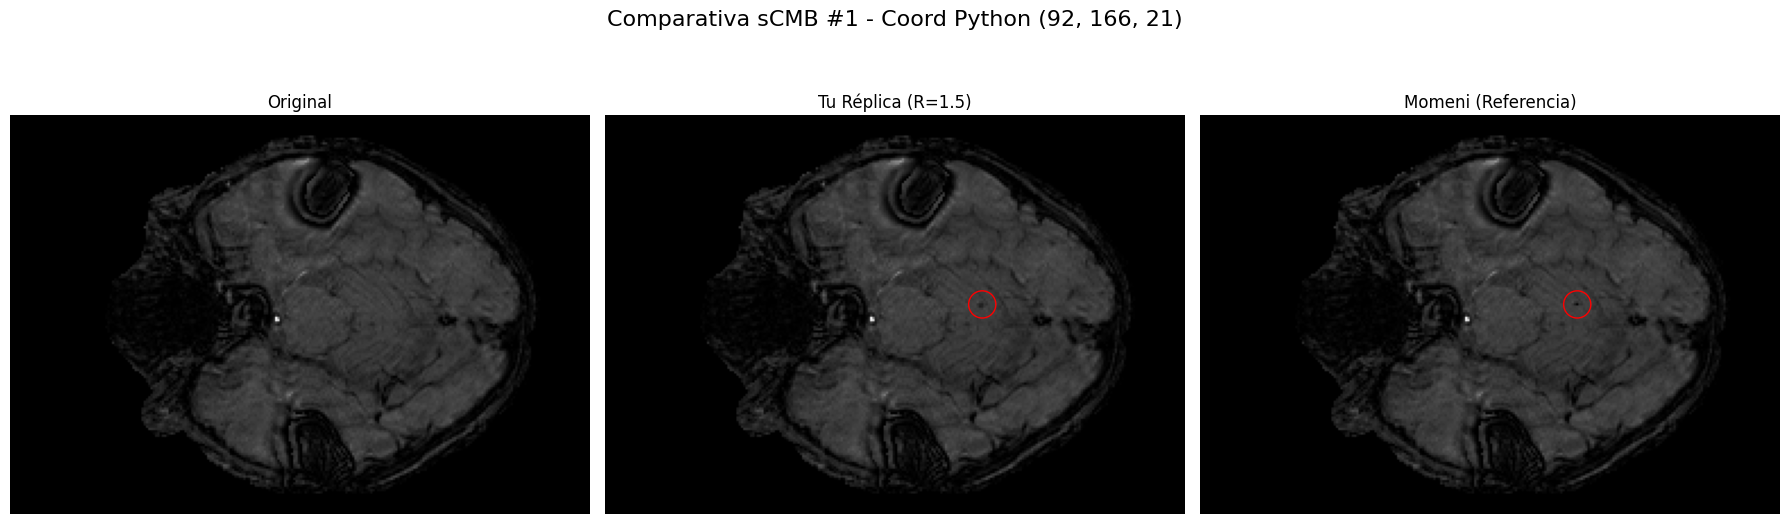

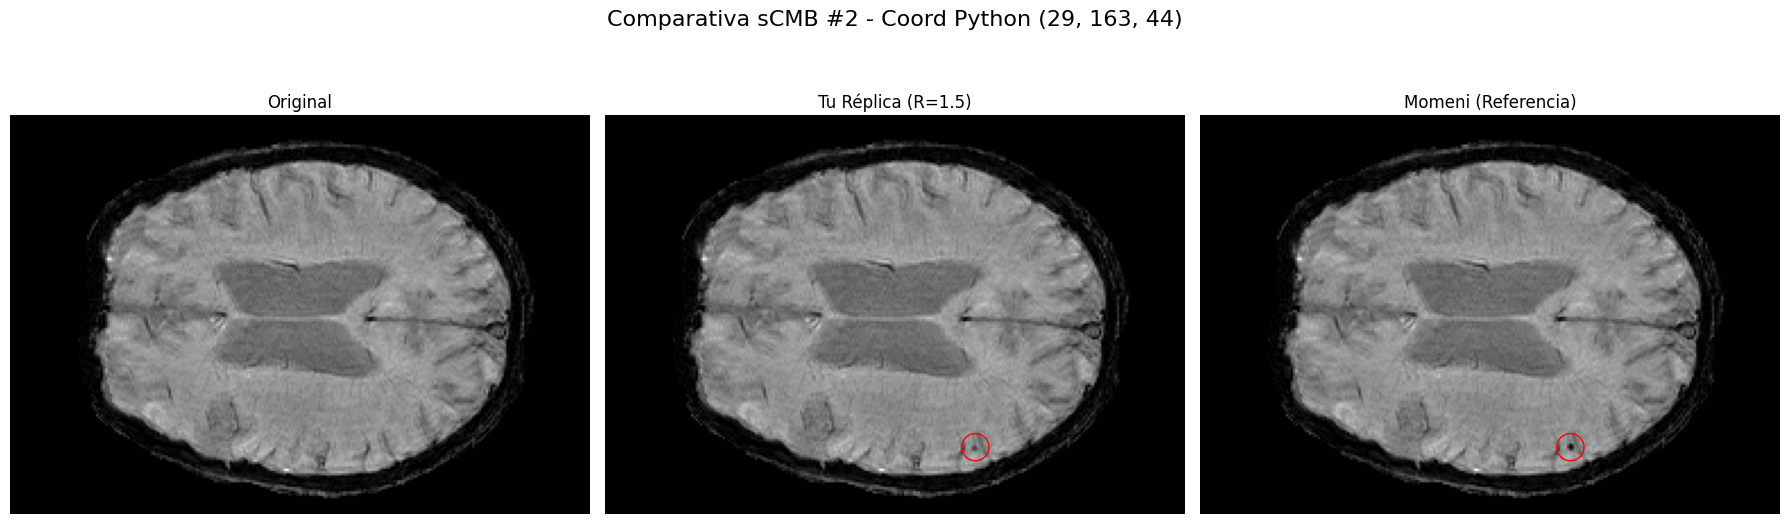

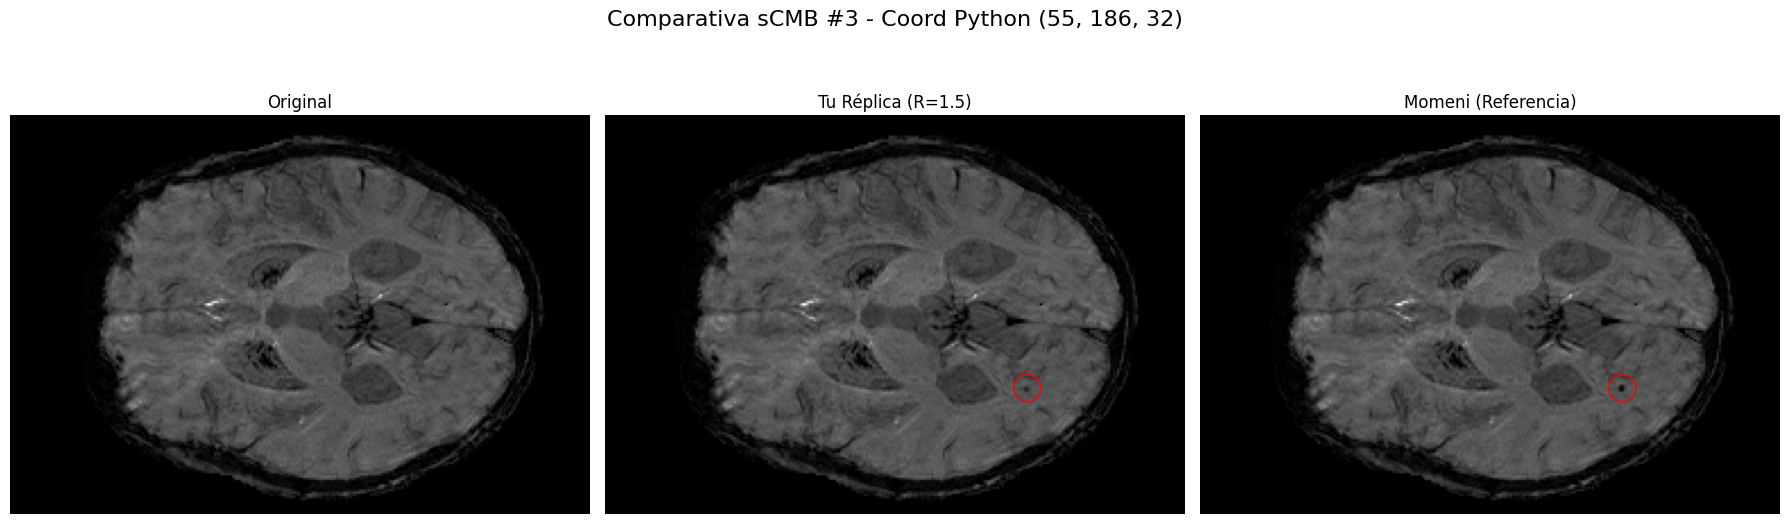

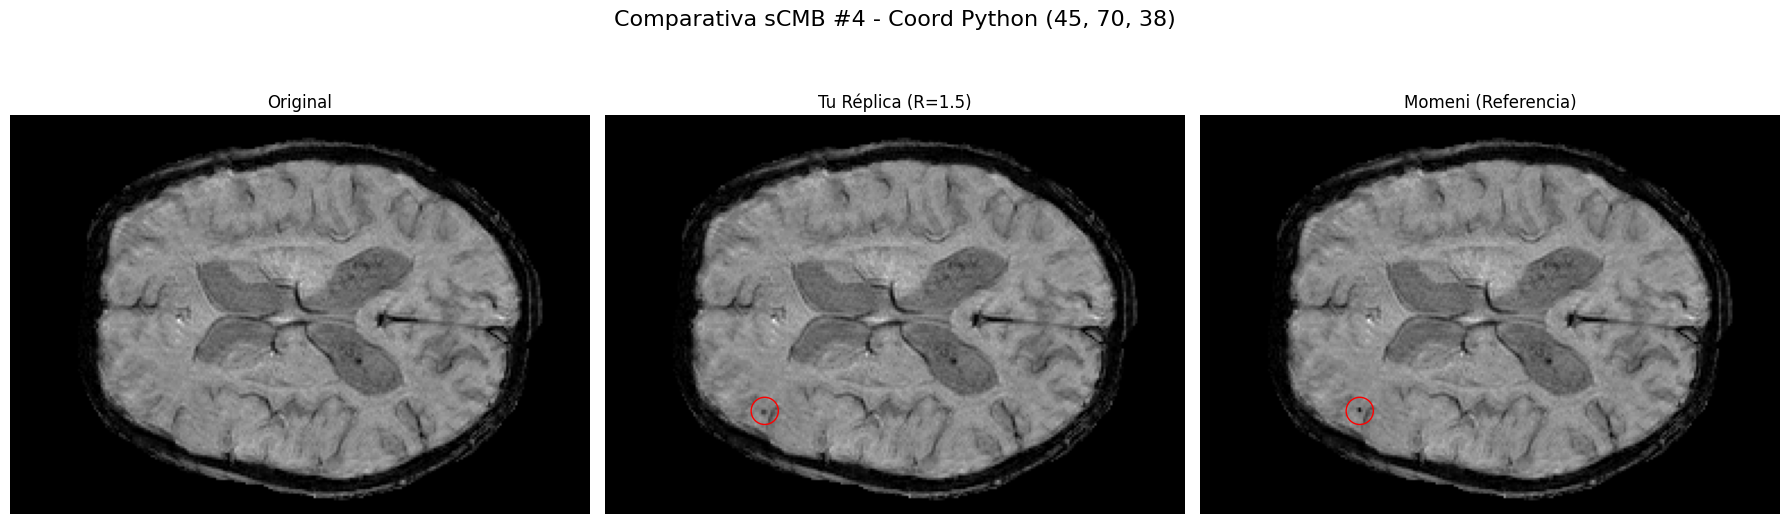

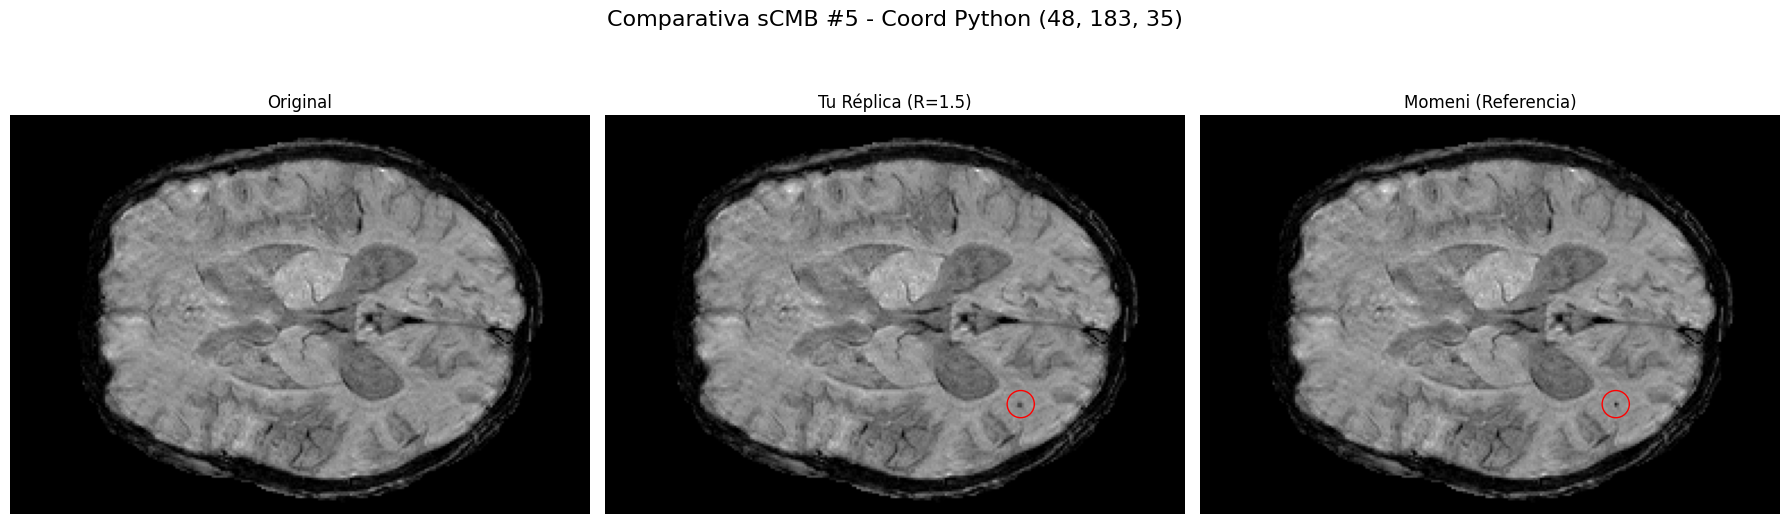

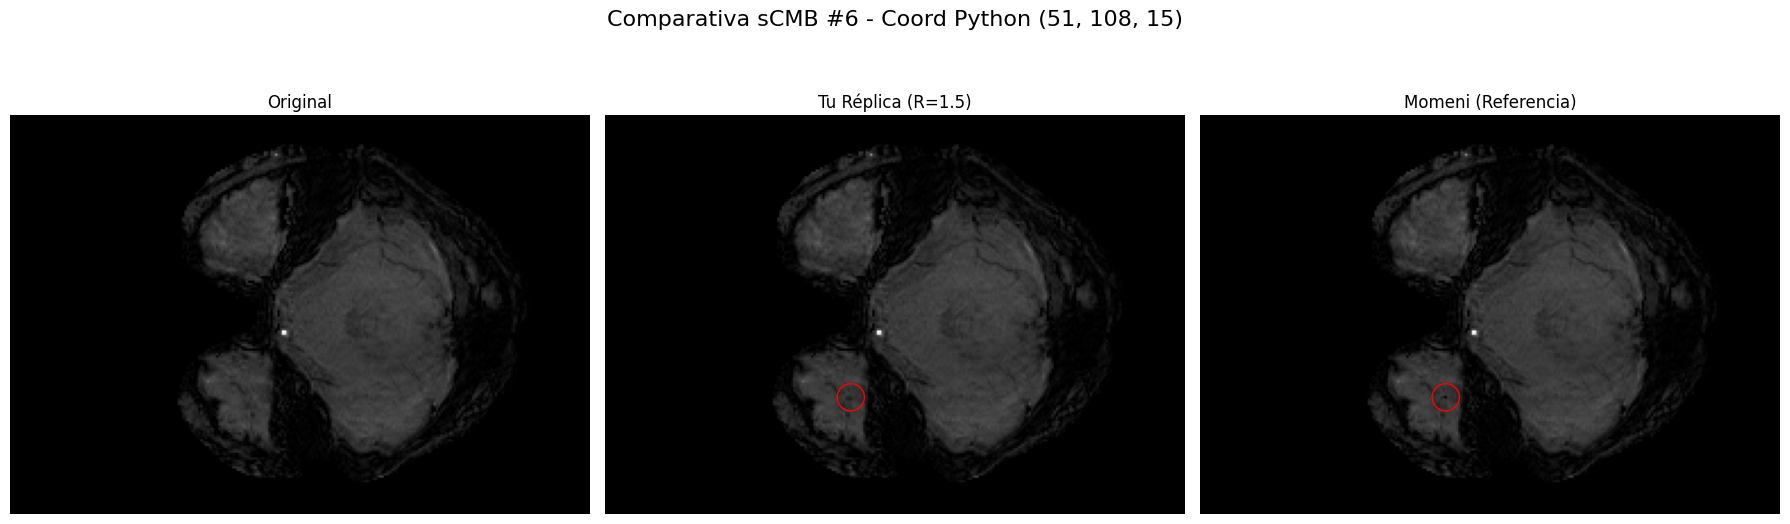

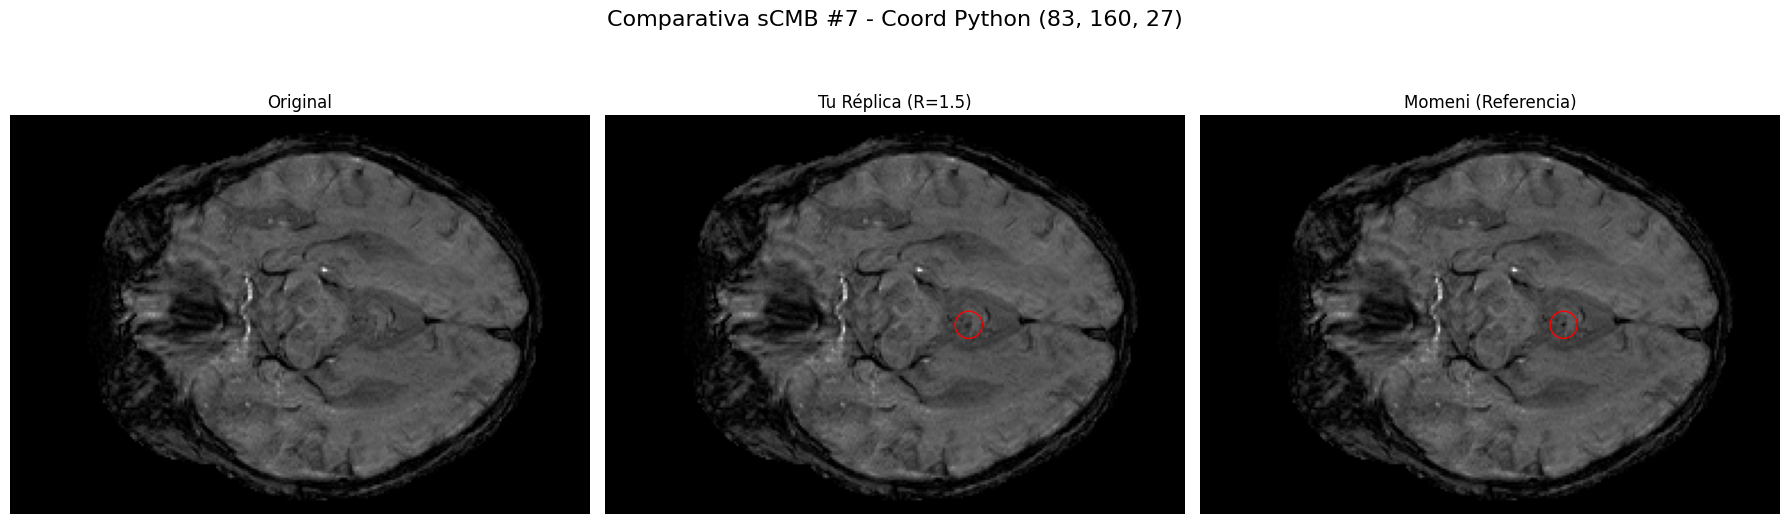

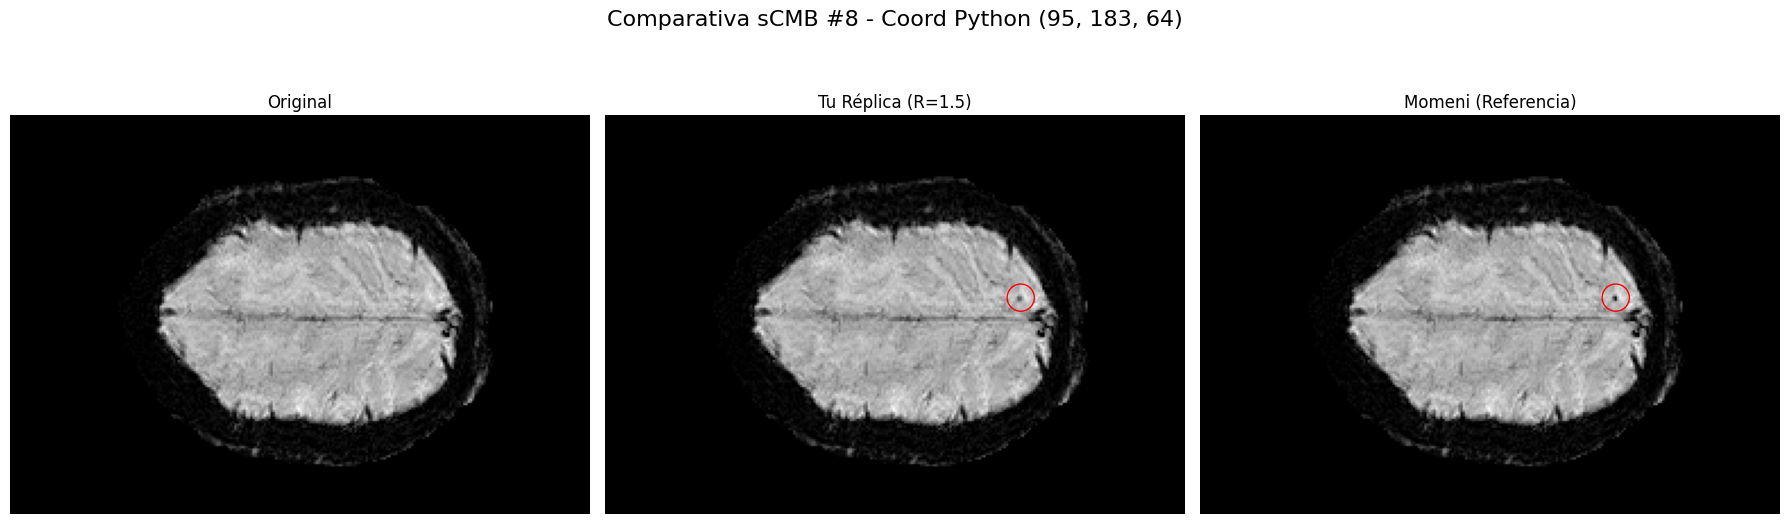

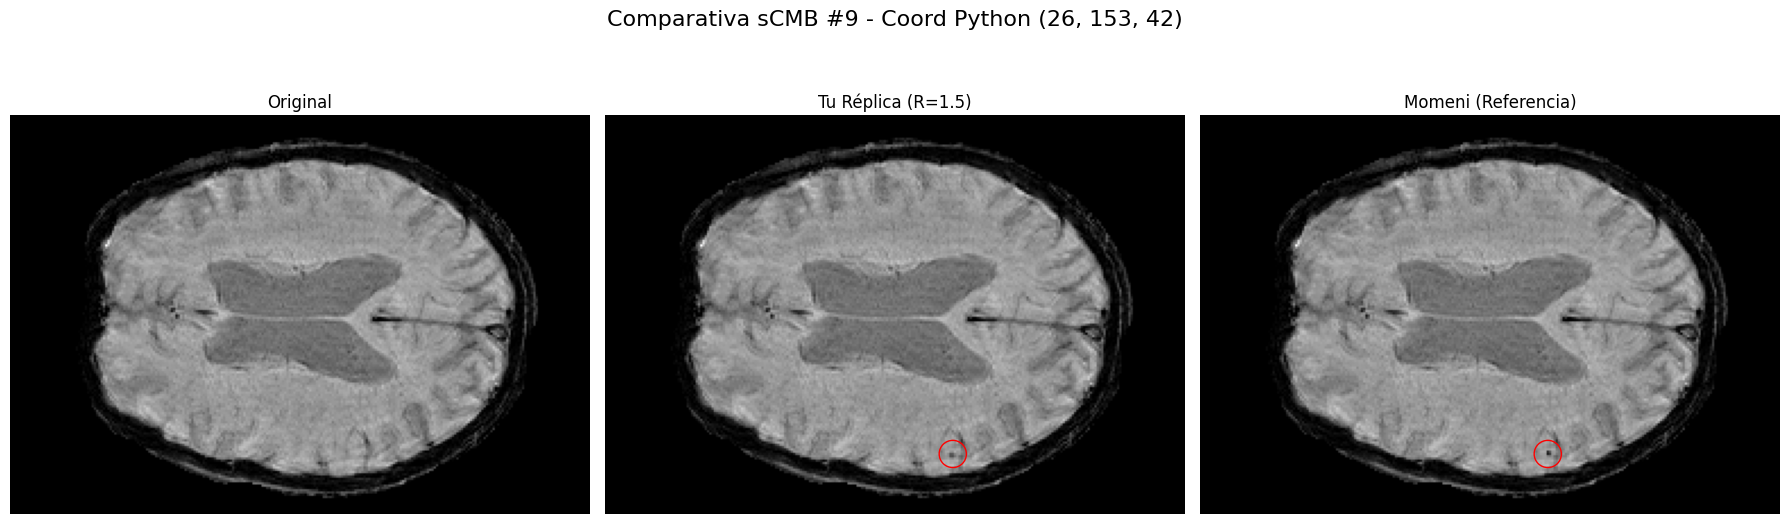

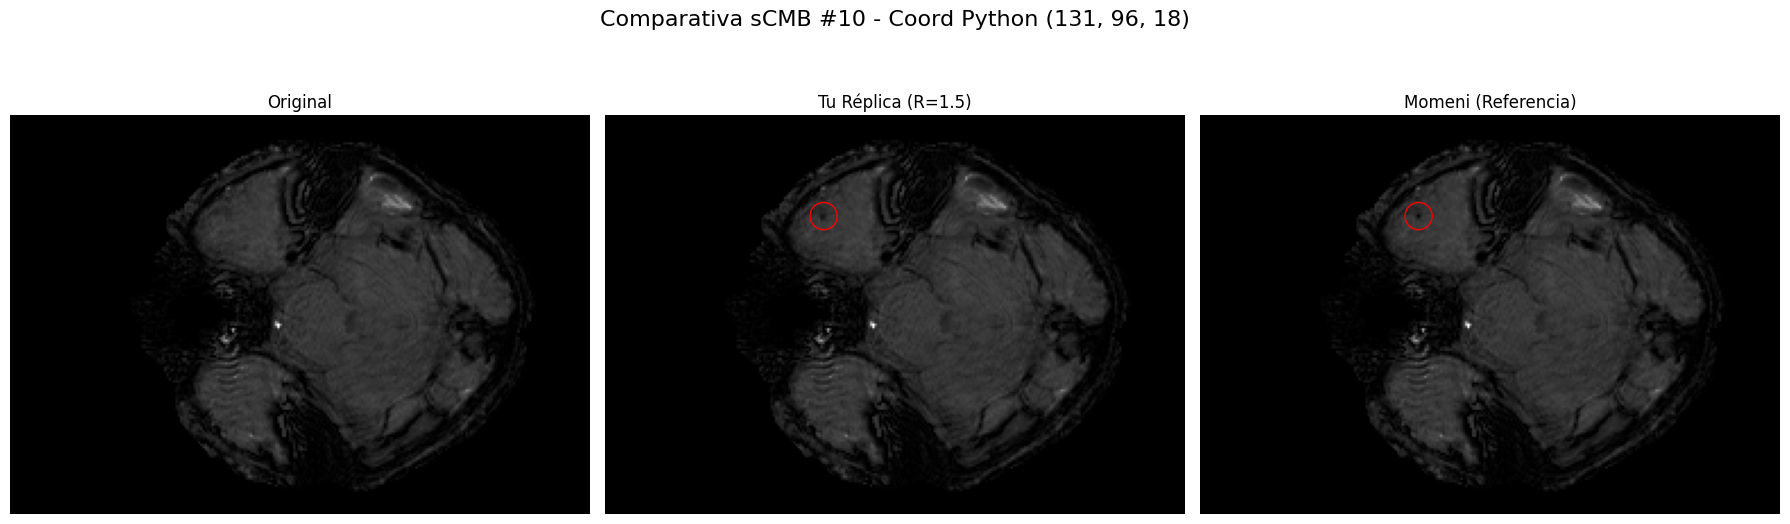

In [25]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib

# ==========================================
# 1. RUTAS
# ==========================================
BASE_DIR = "/media/PORT-DISK/Practicas/MicroBleeds_Generation/momeni2021"
PATH_ORIGINAL = os.path.join(BASE_DIR, "NoCMB", "101_T1_MRI_SWI_BFC_50mm_HM.nii.gz")
PATH_MOMENI = os.path.join(BASE_DIR, "NoCMB_sCMB", "101_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1.nii.gz")
PATH_REPLICA = os.path.join(BASE_DIR, "sCMBS_Replica_Momeni", "101_Replica_Comparativa_10Lesions.nii.gz")

# Coordenadas ORIGINALES (Base 1)
RAW_COORDINATES = [
    (93, 167, 22), (30, 164, 45), (56, 187, 33), (46, 71, 39), (49, 184, 36),
    (52, 109, 16), (84, 161, 28), (96, 184, 65), (27, 154, 43), (132, 97, 19)
]

# --- CORRECCIÓN PARA VISUALIZAR (Base 0) ---
COORDINATES_LIST = [(x-1, y-1, z-1) for (x, y, z) in RAW_COORDINATES]

# ==========================================
# 2. VISUALIZACIÓN
# ==========================================
print("Cargando volúmenes...")
if os.path.exists(PATH_REPLICA):
    img_orig = nib.load(PATH_ORIGINAL).get_fdata()
    img_momeni = nib.load(PATH_MOMENI).get_fdata()
    img_replica = nib.load(PATH_REPLICA).get_fdata()

    print("Generando comparativas...")
    
    for i, coord in enumerate(COORDINATES_LIST):
        cx, cy, cz = coord
        
        # Ajustamos el círculo rojo al radio visualizado (aprox)
        # Como hemos inyectado R=1.5, un círculo de R=5 debería rodearla bien sin taparla
        VIS_CIRCLE_RADIUS = 6 
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"Comparativa sCMB #{i+1} - Coord Python {coord}", fontsize=16)
        
        # Coordenadas Matplotlib (x=columna, y=fila) -> (cy, cx)
        plot_x = cy 
        plot_y = cx 
        
        # --- COL 1: ORIGINAL ---
        axes[0].imshow(img_orig[:, :, cz], cmap="gray", origin="lower")
        axes[0].set_title("Original")
        axes[0].axis("off")
        
        # --- COL 2: TU RÉPLICA (MINI) ---
        axes[1].imshow(img_replica[:, :, cz], cmap="gray", origin="lower")
        axes[1].set_title("Tu Réplica (R=1.5)")
        axes[1].axis("off")
        c1 = patches.Circle((plot_x, plot_y), radius=VIS_CIRCLE_RADIUS, edgecolor='red', facecolor='none', linewidth=1)
        axes[1].add_patch(c1)
        
        # --- COL 3: MOMENI (GROUND TRUTH) ---
        axes[2].imshow(img_momeni[:, :, cz], cmap="gray", origin="lower")
        axes[2].set_title("Momeni (Referencia)")
        axes[2].axis("off")
        c2 = patches.Circle((plot_x, plot_y), radius=VIS_CIRCLE_RADIUS, edgecolor='red', facecolor='none', linewidth=1)
        axes[2].add_patch(c2)
        
        plt.tight_layout()
        plt.show()

### IDEAS DE COMPARATIVAS:
- PERFIL DE INTENSIDAD 1D
- MAPA DE DIFERENCIA
- MÉTRICAS DE SIMILITUD ESTRUCTURAL
- HISOGRAMA DE LA ROI
- CONTRAST-TO-NOISE RATIO (CNR)
